# Imports

In [1]:
import os
import platform

import tensorflow as tf
import tensorflow.keras as tfk

import numpy as np 

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import network.models as netmods
import keras_tuner as kt

from matminer.datasets.convenience_loaders import load_castelli_perovskites
import matminer.featurizers.structure as sfeat
import matminer.featurizers.composition as cfeat
import matminer.featurizers.conversions as confeat
import matminer.featurizers.site as site


from sklearn.ensemble import RandomForestRegressor

# Temporary packages for debugging
from IPython.display import clear_output


# Alias important packages


tfkl = tf.keras.layers

# Set seed value
SEED = 10

# Data Processing

#### Load raw data

In [2]:
# Load all data from the castelli perovskites dataset
dataframe = load_castelli_perovskites() 
dataframe.head()

,fermi level,fermi width,e_form,gap is direct,structure,mu_b,formula,vbm,cbm,gap gllbsc
0,0.312138,0.001837,2.16,True,"[[0. 0. 0.] Rh, [1.97726555 1.97726555 1.97726...",1.974478e-02,RhTeN3,6.187694,6.187694,0.0
1,0.297083,0.001837,1.52,True,"[[2.54041798 0. 0. ] Hf, [1.020...",-2.253054e-05,HfTeO3,6.033125,6.033125,0.0
2,0.191139,0.003675,1.48,True,"[[0.60790913 0. 0. ] Re, [2.186...",4.982109e+00,ReAsO2F,6.602253,6.602253,0.0
3,0.316346,0.001837,1.24,True,"[[2.83091357 0. 0. ] W, [2.6573...",-8.684496e-01,WReO2S,5.738462,5.738462,0.0
4,0.312658,0.003675,0.62,True,"[[0.00518937 0. 0. ] Bi, [2.172...",2.164069e-15,BiHfO2F,6.074736,6.074736,0.0


## Coulomb Matrix dataset

#### Organize and cure CM dataset

In [ ]:
# Remove the properties we do not wish to incorporate into our model

dataframe = dataframe[dataframe["gap is direct"] != False]

# Isolate material structure

structure_list = dataframe.loc[:,"structure"]

# Define featurizers to convert structural data that is available prior to the scf DFT calculations

DFfeaturizer = sfeat.DensityFeatures("density")
CMfeaturizer = sfeat.CoulombMatrix()
SCfeaturizer = sfeat.StructuralComplexity(symprec=5e-2) # Featurizer to get the structural complexity of the lattice structures

CMStructure = CMfeaturizer.fit(structure_list)

X_i = []

#num_structures = len(structure_list)

#coulomb_matrix = CMfeaturizer.featurize(QMStructure) 

for i,structure in enumerate(structure_list):
    X_i = [
        *CMStructure.featurize(structure),
        #*DFfeaturizer.featurize(structure)
    ]
    

    if(i == 0):
        X_data = np.array(X_i)
    else:
        X_data = np.vstack([X_data,X_i])
    
Y_data = np.array([dataframe.loc[:,"fermi level"],dataframe.loc[:,"fermi width"],dataframe.loc[:,"e_form"],dataframe.loc[:,"cbm"],dataframe.loc[:,"vbm"]]).T



#### Save processed CM dataset

In [ ]:
finp = "CMinputs.txt"
fout = "CMoutputs.txt"
folder = "data"


if not os.path.isdir(folder):
    os.mkdir(folder)

if(platform.system() == 'Linux' or platform.system() == 'Darwin'):
    finp_path = folder + "/" + finp 
    fout_path = folder + "/" + fout
elif(platform.system() == 'Windows'):
    finp_path = folder + "\\" + finp
    fout_path = folder + "\\" + fout

fileID = open(finp_path,'w')
np.savetxt(finp_path,X_data)
fileID.close()

fileID = open(fout_path,'w')
np.savetxt(fout_path,Y_data)
fileID.close()

#### Load processed CM dataset

In [2]:
finp = "SNNinputs.txt"
fout = "SNNoutputs.txt"
folder = "data"

if(platform.system() == 'Linux' or platform.system() == 'Darwin'):
    finp_path = folder + "/" + finp 
    fout_path = folder + "/" + fout
elif(platform.system() == 'Windows'):
    finp_path = folder + "\\" + finp
    fout_path = folder + "\\" + fout

X_data = np.loadtxt(finp_path)
Y_data = np.loadtxt(fout_path)

## GNN dataset

#### Organize and cure GNN dataset

In [ ]:
# Isolate material structure
structure_list = dataframe.loc[:,"structure"]

DFfeaturizer = sfeat.DensityFeatures("density")
CMfeaturizer = sfeat.CoulombMatrix()

CMStructure = CMfeaturizer.fit(structure_list)

Struct2Composition = confeat.StructureToComposition()
OxideStates = confeat.StructureToOxidStructure()
ion = cfeat.IonProperty()
Ea = cfeat.ElectronAffinity()

rcut = 10
nmax = 2
lmax = 4
sigma = 2
rbf = "gto"
isperiodic = True

FSOAP = site.SOAP(rcut=rcut,nmax=nmax,lmax=lmax,sigma=sigma,rbf=rbf,periodic=isperiodic)


num_skips = 0

data_index = []

for ctr,structure in enumerate(structure_list):
    structure = OxideStates.featurize(structure)
    composition = Struct2Composition.featurize(*structure)
    
    try:
        e_affinity = Ea.featurize(*composition)
    except ValueError:
        num_skips += 1
        continue
    else:

        #FSOAP.fit(*structure)
        #soap = FSOAP.featurize(*structure,0)
        #ion_property = ion.featurize(*composition)
        coulomb_matrix = CMStructure.featurize(*structure)
        #density = DFfeaturizer.featurize(*structure)
        #soap = FSOAP

        X_i = [
            *coulomb_matrix,
            #*e_affinity,
            #*ion_property,
            #*density
        ]

        data_index.append(ctr)

        if(ctr == 0):
            X_data = np.array(X_i)
        else:
            X_data = np.vstack([X_data,X_i])

        
        
        
print(f"Number of entries removed {num_skips}")


Y_data = np.array([dataframe.loc[:,"fermi level"],dataframe.loc[:,"fermi width"],dataframe.loc[:,"e_form"],dataframe.loc[:,"cbm"],dataframe.loc[:,"vbm"]]).T
Y_data = Y_data[data_index][:]

#### Save processed GNN dataset

In [ ]:
finp = "GNNinputs.txt"
fout = "GNNoutputs.txt"
folder = "data"


if not os.path.isdir(folder):
    os.mkdir(folder)

if(platform.system() == 'Linux' or platform.system() == 'Darwin'):
    finp_path = folder + "/" + finp 
    fout_path = folder + "/" + fout
elif(platform.system() == 'Windows'):
    finp_path = folder + "\\" + finp
    fout_path = folder + "\\" + fout

fileID = open(finp_path,'w')
np.savetxt(finp_path,X_data)
fileID.close()

fileID = open(fout_path,'w')
np.savetxt(fout_path,Y_data)
fileID.close()

#### Load processed GNN dataset

In [2]:
finp = "GNNinputs.txt"
fout = "GNNoutputs.txt"
folder = "data"

if(platform.system() == 'Linux' or platform.system() == 'Darwin'):
    finp_path = folder + "/" + finp 
    fout_path = folder + "/" + fout
elif(platform.system() == 'Windows'):
    finp_path = folder + "\\" + finp
    fout_path = folder + "\\" + fout

X_data = np.loadtxt(finp_path)
Y_data = np.loadtxt(fout_path)

# Standard Neural Networks

#### Configure data

In [ ]:
X_shuffled, Y_shuffled = shuffle([X_data,Y_data],random_state=SEED)
X_train,X_test,Y_train,Y_test = train_test_split(X_shuffled,Y_shuffled,test_size=0.1)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2)


batch_size = 50
num_epochs = int(1000)

feature_ndims = X_train.shape[1]

# Here we define the callbacks which we want to use
early_stopping_callback = tfk.callbacks.EarlyStopping(patience=10)
tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=".\\tmp\\logs")

callbacks = [early_stopping_callback,tensorboard_callback]

# The rest of the model is configured in the layers.py file - The HyperModel class is constructed in such a way that we sample different hyperparameters

#### Hyperparameter tuning

##### Fermi Level

In [ ]:
fermi_level_train = Y_train[:,0]
fermi_level_val = Y_val[:,0]
fermi_level_test = Y_test[:,0]

hyperparameters = kt.HyperParameters()
hypermodel = netmods.HyperModel(feature_ndims)
rand_tuner = kt.RandomSearch(hypermodel = hypermodel.build_model,max_trials=150,overwrite=True,objective='val_loss',directory=".\\tmp\\hptune")

rand_tuner.search(x=X_train,y=fermi_level_train,validation_data=(X_val,fermi_level_val),epochs=num_epochs,batch_size=batch_size,callbacks=callbacks)


#### Network Training

In [3]:
import shutil
shutil.rmtree(".\\tmp")


In [4]:
%tensorboard --logdir /tmp/logs

UsageError: Line magic function `%tensorboard` not found.


In [5]:
scale_factor = 1e3
X_data_scaled = np.divide(X_data,scale_factor)

X_shuffled, Y_shuffled = shuffle([X_data_scaled,Y_data],random_state=SEED)
X_train,X_test,Y_train,Y_test = train_test_split(X_shuffled,Y_shuffled,test_size=0.1)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2)

feature_ndims = X_train.shape[1]

fermi_level_train = Y_train[:,2]
fermi_level_val = Y_val[:,2]
fermi_level_test = Y_test[:,2]


Qmodel_test = netmods.fermi_level_model(feature_ndims)

# Check if we can overfit the model (ie. does it even learn?)

Qmodel_test.fit(x=X_train[0:2,:],y=fermi_level_train[0:2],epochs=400,verbose=0)

print(f"Prediction: {Qmodel_test.predict(X_train[0:2,:])}")
print(f"Truth: {fermi_level_train[0:2]}")

Prediction: [[1.7022982 ]
 [0.94210994]]
Truth: [2.06 0.82]


In [6]:
# Here we define the callbacks which we want to use
batch_size = 100
val_batch_size = 50
num_epochs = 3000


early_stopping_callback = tfk.callbacks.EarlyStopping(patience=20)
tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=".\\tmp\\logs")

Qmodel = netmods.fermi_level_model(feature_ndims)

callbacks = [early_stopping_callback,tensorboard_callback]

Qmodel.fit(x=X_train,y=fermi_level_train,validation_data=(X_val,fermi_level_val),epochs=num_epochs,batch_size=batch_size,shuffle=True,callbacks=callbacks)

Epoch 1/3000
124/124 [==============================] - 3s 14ms/step - loss: 0.5516 - val_loss: 0.6087
Epoch 2/3000
124/124 [==============================] - 1s 10ms/step - loss: 0.5195 - val_loss: 0.5762
Epoch 3/3000
124/124 [==============================] - 1s 12ms/step - loss: 0.5192 - val_loss: 0.5344
Epoch 4/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.5136 - val_loss: 0.5233
Epoch 5/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.5130 - val_loss: 0.5294
Epoch 6/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.5117 - val_loss: 0.5312
Epoch 7/3000
124/124 [==============================] - 1s 8ms/step - loss: 0.5111 - val_loss: 0.5195
Epoch 8/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.5099 - val_loss: 0.5261
Epoch 9/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.5085 - val_loss: 0.5213
Epoch 10/3000
124/124 [==============================] - 1s 9ms/step - loss: 0.

In [ ]:
model_dir = "\\model\\bgmodel"
Qmodel.save(model_dir)

#### Model Validation

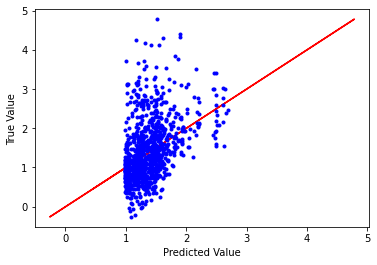

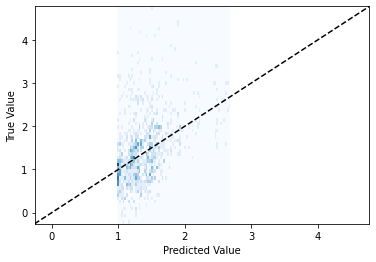

In [7]:
sample_points = 1000

X_test_sample = X_test[0:sample_points]
y_test_sample = Y_test[0:sample_points]

Qmodel.parity_plot(X_test_sample,y_test_sample,sample_dims=2)

Qmodel.parity_patch_plot(X_test_sample,y_test_sample,sample_dims=2)

# Random Forests

### Data configuration

In [3]:
from sklearn.metrics import mean_absolute_error as mae
from utils.viewer import patch_parity_plot,parity_plot

X_shuffled,Y_shuffled = shuffle([X_data,Y_data],random_state=SEED)

X_train,X_test,Y_train,Y_test = train_test_split(X_shuffled,Y_shuffled,test_size=0.2)

fermi_level_train = Y_train[:,0]
fermi_level_test = Y_test[:,0]

fermi_width_train = Y_train[:,1]
fermi_width_test = Y_test[:,1]

eform_train = Y_train[:,2]
eform_test = Y_test[:,2]

cbm_train = Y_train[:,3]
cbm_test = Y_test[:,3]

vbm_train = Y_train[:,4]
vbm_test = Y_test[:,4]


## Random Forests Fitting

##### Fermi level

In [4]:
fermi_level_rfmodel = RandomForestRegressor(n_estimators=500, random_state=SEED)
fermi_level_rfmodel.fit(X_train,fermi_level_train)

print(f"Training Mean Absolute Error: {mae(y_true=fermi_level_train,y_pred=fermi_level_rfmodel.predict(X_train))}")

Training Mean Absolute Error: 0.007847898780718962


##### Conduction Band Minimum

In [9]:
cbm_rfmodel = RandomForestRegressor(n_estimators=500, random_state=SEED)
cbm_rfmodel.fit(X_train,cbm_train)

print(f"Training Mean Absolute Error: {mae(y_true=cbm_train,y_pred=cbm_rfmodel.predict(X_train))}")

Training Mean Absolute Error: 3.531081359344517e-07


#### Energy of formation

In [11]:
eform_rfmodel = RandomForestRegressor(n_estimators=500,random_state=SEED)
eform_rfmodel.fit(X_train,eform_train)

print(f"Training Mean Absolute Error: {mae(y_true=eform_train,y_pred=eform_rfmodel.predict(X_train))}")

Training Mean Absolute Error: 0.091580068194217


## Model evaluations

#### Fermi level

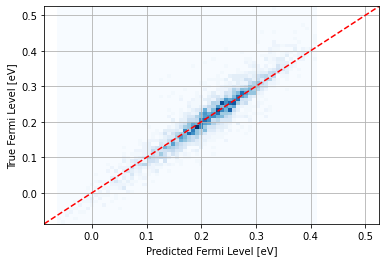

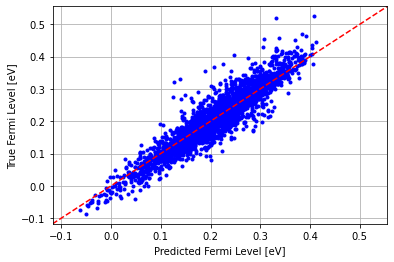

In [12]:
patch_parity_plot(model=fermi_level_rfmodel,X=X_test,y_truth=fermi_level_test,labels=["Predicted Fermi Level [eV]","True Fermi Level [eV]"])
parity_plot(model=fermi_level_rfmodel,X=X_test,y_truth=fermi_level_test,labels=["Predicted Fermi Level [eV]","True Fermi Level [eV]"])


#### Conduction Band Minimum

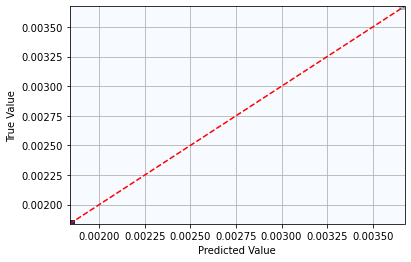

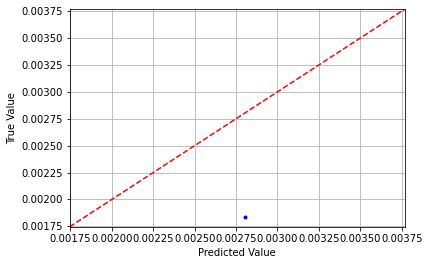

In [10]:
patch_parity_plot(model=fermi_width_rfmodel,X=X_test,y_truth=fermi_width_test)
parity_plot(fermi_level_rfmodel,X_test,fermi_width_test)

#### Energy of formation

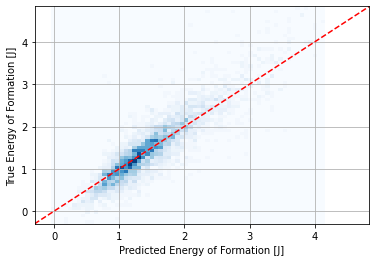

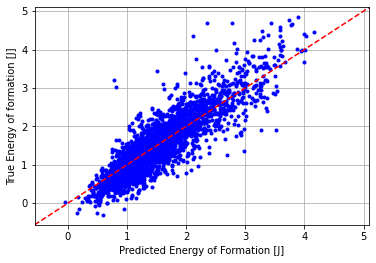

In [9]:
patch_parity_plot(model=eform_rfmodel,X=X_test,y_truth=eform_test,labels=["Predicted Energy of Formation [J]","True Energy of Formation [J]"])
parity_plot(model=eform_rfmodel,X=X_test,y_truth=eform_test,labels=["Predicted Energy of Formation [J]","True Energy of formation [J]"])